In [1]:
from google.colab import files
uploaded = files.upload()

Saving simulated_fare_with_two_features.csv to simulated_fare_with_two_features.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import json
import time

**Mengambil data dari file csv**

   Distance     Type  Fare
0      2210  Student  2000
1      2234  General  3000
2      2345  Student  2000
3      2345  General  3000
4      2345  General  4000


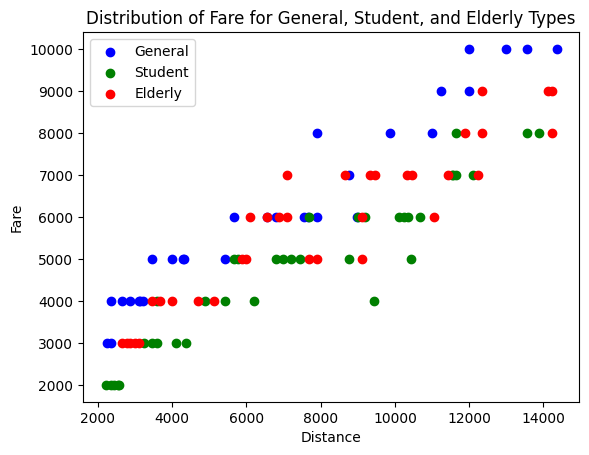

In [3]:
file_path = 'simulated_fare_with_two_features.csv'
data = pd.read_csv(file_path, sep = ",")
print(data.head())

color_mapping = {'General': 'blue', 'Student': 'green', 'Elderly': 'red'}

for type_name, color in color_mapping.items():
    type_data = data[data['Type'] == type_name]
    plt.scatter(type_data['Distance'], type_data['Fare'], c=color, label=type_name)

plt.xlabel('Distance')
plt.ylabel('Fare')
plt.title('Distribution of Fare for General, Student, and Elderly Types')
plt.legend()
plt.show()

# **Pengembangan Model**

**Data Preprocessing**

In [4]:
X = data[["Distance", "Type"]]
y = data["Fare"]
X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mean_X, std_X = np.mean(X_train, axis=0), np.std(X_train, axis=0)
mean_y, std_y = np.mean(y_train, axis=0), np.std(y_train, axis=0)

X_train = (X_train - mean_X) / std_X
X_test = (X_test - mean_X) / std_X

y_train = (y_train - mean_y) / std_y
y_test = (y_test - mean_y) / std_y

**Arsitektur Model**

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(units=8, activation='relu'),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='linear')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

model.fit(X_train, y_train, epochs=200, verbose=1)


Epoch 1/200
3/3 [==============================] - 2s 12ms/step - loss: 1.3558 - mse: 1.3558
Epoch 2/200
3/3 [==============================] - 0s 8ms/step - loss: 1.2896 - mse: 1.2896
Epoch 3/200
3/3 [==============================] - 0s 8ms/step - loss: 1.2386 - mse: 1.2386
Epoch 4/200
3/3 [==============================] - 0s 11ms/step - loss: 1.1828 - mse: 1.1828
Epoch 5/200
3/3 [==============================] - 0s 9ms/step - loss: 1.1308 - mse: 1.1308
Epoch 6/200
3/3 [==============================] - 0s 10ms/step - loss: 1.0775 - mse: 1.0775
Epoch 7/200
3/3 [==============================] - 0s 6ms/step - loss: 1.0305 - mse: 1.0305
Epoch 8/200
3/3 [==============================] - 0s 10ms/step - loss: 0.9893 - mse: 0.9893
Epoch 9/200
3/3 [==============================] - 0s 8ms/step - loss: 0.9440 - mse: 0.9440
Epoch 10/200
3/3 [==============================] - 0s 8ms/step - loss: 0.9068 - mse: 0.9068
Epoch 11/200
3/3 [==============================] - 0s 7ms/step - loss: 0.8

**Menguji Model**

In [6]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on Test Data: {mse}')

1/1 [==============================] - 0s 349ms/step
Mean Squared Error on Test Data: 0.059613431718440364


**Visualisasi Hasil Prediksi**

In [7]:
X_test_denormalized = X_test * std_X + mean_X
y_test_denormalized = y_test * std_y + mean_y
y_pred_denormalized = y_pred * std_y + mean_y

import plotly.graph_objects as go

# Visualisasi hubungan antara variabel Distance, Type, dan Fare menggunakan Plotly
fig = go.Figure(data=[
    go.Scatter3d(
        x=X_test_denormalized['Distance'],
        y=X_test_denormalized['Type_Student'],
        z=y_test_denormalized,
        mode='markers',
        name='True Fare',
        marker=dict(size=4)
    ),
    go.Scatter3d(
        x=X_test_denormalized['Distance'],
        y=X_test_denormalized['Type_Student'],
        z=y_pred_denormalized.flatten(),
        mode='markers',
        name='Predicted Fare',
        marker=dict(size=4)
    )
])

fig.update_layout(
    scene=dict(
        xaxis=dict(title='Distance'),
        yaxis=dict(title='Type'),
        zaxis=dict(title='Fare'),
    ),
    title='Relationship between Distance, Type, and Fare',
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()


**Tes Model dengan data baru**

In [9]:
test_values = pd.DataFrame({'Distance': [10000, 10000, 10000],
                            'Type_General': [1, 0, 0],
                            'Type_Student': [0, 1, 0],
                            'Type_Elderly': [0, 0, 1]})

test_values_normalized = (test_values - mean_X) / std_X

predicted_fares_normalized = model.predict(test_values_normalized)

predicted_fares_denormalized = predicted_fares_normalized * std_y + mean_y

for i in range(len(test_values)):
    predicted_fare_denormalized = predicted_fares_denormalized[i][0]
    rounded_predicted_fare = np.round(predicted_fare_denormalized / 1000) * 1000
    fare_type = test_values.iloc[i, 1:].idxmax()

    print(f'Jarak: {test_values["Distance"][i]}, Type: {fare_type}, Predicted Fare (Rounded): {rounded_predicted_fare}')


1/1 [==============================] - 0s 34ms/step
Jarak: 10000, Type: Type_General, Predicted Fare (Rounded): 8000.0
Jarak: 10000, Type: Type_Student, Predicted Fare (Rounded): 6000.0
Jarak: 10000, Type: Type_Elderly, Predicted Fare (Rounded): 7000.0


# **Convert Model**

Install tensorflowjs

In [10]:
pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 90.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 79.6 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalle

Save model ke format .h5

In [10]:
saved_model_path = "./{}.h5".format(int(time.time()))

model.save(saved_model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



Konversi model menggunakan tensorflowjs

In [11]:
!tensorflowjs_converter --input_format=keras {saved_model_path} ./


2023-12-08 10:49:47.589213: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 10:49:47.589299: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 10:49:47.591073: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-08 10:49:49.568856: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# **Menyimpan Paramater Normalization ke dalam file JSON**

In [16]:
print(f'mean_X: {mean_X}')
print(f'std_X:  {std_X}')
print(f'mean_y: {mean_y}')
print(f'std_y:  {std_y}')

result_dict = {
    "mean_X": mean_X.to_dict(),
    "std_X": std_X.to_dict(),
    "mean_y": float(mean_y),
    "std_y": float(std_y)
}

# Save to JSON file
with open('norm_params.json', 'w') as json_file:
    json.dump(result_dict, json_file, indent=4)


mean_X: Distance        7516.481481
Type_Elderly       0.358025
Type_General       0.308642
Type_Student       0.333333
dtype: float64
std_X:  Distance        3568.436079
Type_Elderly       0.479419
Type_General       0.461933
Type_Student       0.471405
dtype: float64
mean_y: 5666.666666666667
std_y:  2024.5407953653998
